# Advanced lane lines

## Camera calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os

### Compute distortion correction coefficients and save them for later use

In [ ]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# Perform calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
print('calibration data available')

In [ ]:
# Let's save the distortion correction coefficients
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

### Let's see an example of distortion correction

In [ ]:
img = cv2.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('camera_cal/report_example.jpg', dpi=500, bbox_inches='tight')

that's it! It looks like our camera is properly calibrated, we can continue our work.

## Image pipeline

#### Load pickled distortion correction information

In [ ]:
import pickle

if 'mtx' in globals() and 'dist' in globals(): # Check if we need to load calibration data from the pickled file
    print('Data already available')
else:
    dist_pickle = pickle.load(open("camera_cal/wide_dist_pickle.p", "rb"))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    print('Data loaded')

In [ ]:
def test_image_pipeline(full=True, gray=False, save=False):
    test_images = glob.glob('test_images/*.jpg')
    for img_name in test_images:
        img = plt.imread(img_name)
        undist = image_pipeline(img)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        if gray is False:
            ax2.imshow(undist)
        else:
            ax2.imshow(undist, cmap='gray')
        ax2.set_title('Pipeline Image', fontsize=30)
        if save is not False:
            plt.savefig(os.path.join(img_name.split('\\')[0], save , img_name.split('\\')[-1]), dpi=500, bbox_inches='tight')
        if full is False:
            break

#### First step of the pipeline: undistord the images

In [ ]:
# Pipeline implementation at this point in time
def image_pipeline(img):
    # Undistord image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [ ]:
# Let's have a look
test_image_pipeline(True, False, "cali_out")

#### Now let's progressively implement the image pipeline

In [ ]:
def image_pipeline(img, s_thresh=(150, 255), sx_thresh=(35, 100)):
    """ This pipeline uses exactly the same principle as the one seen in class
    1- undistort image
    2- convert to HLS color space
    3- apply x gradient using Sobel and apply threshold
    4- apply threshold on the S channel
    5- combine all conditions and stack the channels into a single image
    """
    img = np.copy(img)
    # Undistord image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

In [ ]:
test_image_pipeline(True, True, False)

Now that the lane pixels have been identified, it's time to perform a perspective transform in order to get a bird eye's view of the lane markings in front of the vehicle

#### Perspective transform

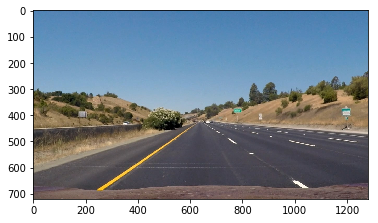

In [3]:
# Let's select an image where the lanes are straight
img = plt.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])
plt.imshow(img)
plt.show()

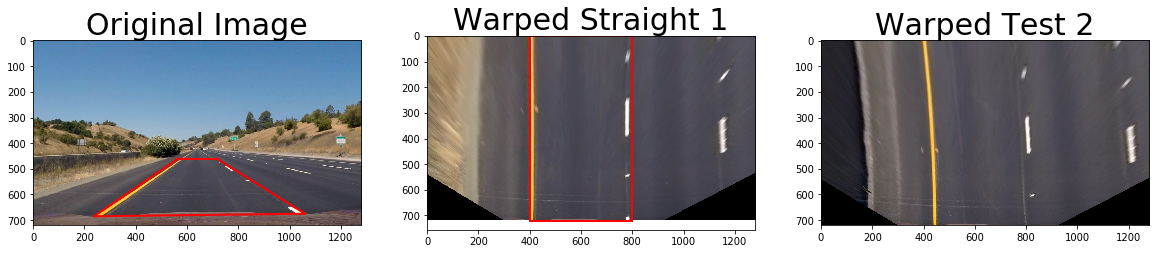

In [4]:
# We can define source and destination points for the perspective transform
src = np.float32([
    [238, 685],  # These points were defined using the matplotlib gui window
    [606, 437],
    [672, 437],
    [1060, 675]
])

src = np.float32([
    [238, 685],  # These points were defined using the matplotlib gui window
    [565, 470],
    [725, 470],
    [1060, 665]
])

dst = np.float32([
    [400, img.shape[0]],
    [400, 0],
    [800, 0],
    [800, img.shape[0]]
])

#plt.imshow(img)
#plt.plot(238, 685, 'r.')
#plt.plot(565, 460, 'r.')
#plt.plot(715, 460, 'r.')
#plt.plot(1060, 675, 'r.')

SRC = np.array([[238, 565, 715, 1060], [685, 460, 460, 675], [0, 0, 0, 0]])

# Time to try perspective transform
M = cv2.getPerspectiveTransform(src, dst)

warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
# Let's warp another image
img2 = plt.imread('test_images/test2.jpg')
warped2 = cv2.warpPerspective(img2, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img)
ax1.plot([238, 565], [685, 460], 'r-', lw=2)
ax1.plot([565, 715], [460, 460], 'r-', lw=2)
ax1.plot([715, 1060], [460, 675], 'r-', lw=2)
ax1.plot([1060, 238], [675, 685], 'r-', lw=2)

ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.plot([400, 400], [img.shape[0], 0], 'r-', lw=2)
ax2.plot([400, 800], [0, 0], 'r-', lw=2)
ax2.plot([800, 800], [0, img.shape[0]], 'r-', lw=2)
ax2.plot([800, 400], [img.shape[0], img.shape[0]], 'r-', lw=2)
ax2.set_title('Warped Straight 1', fontsize=30)
ax3.imshow(warped2)
ax3.set_title('Warped Test 2', fontsize=30)

plt.savefig(r'report_data/warp.jpg', dpi=500, bbox_inches='tight')

#### Let's build some lib functions for the pipeline


In [ ]:
def undist_image(img):
    dist_pickle = pickle.load(open("camera_cal/wide_dist_pickle.p", "rb"))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    return cv2.undistort(img, mtx, dist, None, mtx)

def warp_image(img):
    src = np.float32([ [238, 685], [606, 437], [672, 437], [1060, 675] ])
    dst = np.float32([ [400, img.shape[0]], [400, 0], [800, 0], [800, img.shape[0]] ])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

#### Here the latest version of the pipeline

In [ ]:
def image_pipeline(img, s_thresh=(120, 240), sx_thresh=(50, 120)):
    """ This pipeline uses exactly the same principle as the one seen in class
    1- undistort image
    2- convert to HLS color space
    3- apply x gradient using Sobel and apply threshold
    4- apply threshold on the S channel
    5- combine all conditions and stack the channels into a single image
    6- warp the image
    """
    img = np.copy(img)
    # Undistord image
    undist = undist_image(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold hue channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 100) & (h_channel <= 200)] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #combined_binary[(sxbinary == 1)] = 1
    
    warped = warp_image(combined_binary)
    return warped

In [ ]:
test_image_pipeline(False, True, False)

#### Let's fit a polynomial using the sliding window method from the class

In [ ]:
def fitPolynom(binary_warped):
    """ Taken from chapter 33 of the class
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    sliced = int(binary_warped.shape[0]/3)
    histogram = np.sum(binary_warped[sliced:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = 400 #np.argmax(histogram[:midpoint])
    rightx_base = 800 #np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 110
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Plot the result
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Compute curvature in meters 
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/346 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    # Compute the position of the car in the lane
    # for this purpose we compare the position of the detected mid lane with the center of the image
    center = 0.5*binary_warped.shape[1]  # Center of the image
    midlane = left_fitx[0] + 0.5*(right_fitx[0]-left_fitx[0])  # Lane center based on the estimated lanes
    carpos = (center - midlane)*xm_per_pix  # Position of the car, >0 to the left.
    print(carpos)
    return out_img, left_fitx, right_fitx


In [ ]:
img = plt.imread('test_images/straight_lines1.jpg')
warped_image = image_pipeline(img)
out, leftline, rightline = fitPolynom(warped_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(out)
ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
ax2.plot(leftline, ploty, color='yellow')
ax2.plot(rightline, ploty, color='yellow')
ax2.set_title('Warped Straight 1', fontsize=30)



In [ ]:
#def image_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
def image_pipeline(img, s_thresh=(120, 240), sx_thresh=(50, 100)):   
    """ This pipeline uses exactly the same principle as the one seen in class
    1- undistort image
    2- convert to HLS color space
    3- apply x gradient using Sobel and apply threshold
    4- apply threshold on the S channel
    5- combine all conditions and stack the channels into a single image
    6- warp the image
    """
    img = np.copy(img)
    # Undistord image
    undist = undist_image(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS).astype(np.float)
    hsv = cv2.cvtColor(undist, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel = hls[:,:,0] # Added
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold hue channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 0) & (h_channel <= 100)] = 1

    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= 220) & (v_channel <= 255)] = 1

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (v_binary == 1) | (sxbinary == 1)) & (h_binary != 0)] = 1
    
    warped = warp_image(combined_binary)
    out, leftline, rightline = fitPolynom(warped)
    
    return out, leftline, rightline

In [ ]:
def test_image_pipeline(full=True, save=False):
    test_images = glob.glob('test_images/*.jpg')
    for img_name in test_images:
        img = plt.imread(img_name)
        out, leftlane, rightlane = image_pipeline(img)
        #out = image_pipeline(img)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(out, cmap='gray')
        ax2.set_title('Pipeline Image', fontsize=30)
        ploty = np.linspace(0, out.shape[0]-1, out.shape[0] )
        ax2.plot(leftlane, ploty, color='yellow')
        ax2.plot(rightlane, ploty, color='yellow')
        if save is not False:
            plt.imsave(os.path.join(img_name.split('\\')[0], save , img_name.split('\\')[-1]), undist, cmap='gray')
        if full is False:
            break

In [ ]:
test_image_pipeline(False,False)

#### Let's experiment with color spaces, for chosing the best possible combination

In [ ]:
# Let's experience the other color spaces
img = plt.imread('test_images/test5.jpg')
# Undistord image
undist = cv2.undistort(img, mtx, dist, None, mtx)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# Convert to HLS color space and separate the V channel
hsv = cv2.cvtColor(undist, cv2.COLOR_RGB2HSV).astype(np.float)
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS).astype(np.float)
lab = cv2.cvtColor(undist, cv2.COLOR_RGB2LAB).astype(np.float)

h_channel = hls[:,:,0]
h_binary = np.zeros_like(h_channel)
h_binary[(h_channel >= 100) & (h_channel <= 130)] = 1

s_channel = hsv[:,:,1]
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= 150) & (s_channel <= 240)] = 1


v_channel = hsv[:,:,2]
v_binary = np.zeros_like(v_channel)
v_binary[(v_channel >= 220) & (v_channel <= 255)] = 1

l_channel = hls[:,:,1]
l_binary = np.zeros_like(l_channel)
l_binary[(l_channel >= 225) & (l_channel <= 255)] = 1

b_channel = hls[:,:,2]
b_binary = np.zeros_like(b_channel)
b_binary[(b_channel >= 155) & (b_channel <= 200)] = 1


# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= 50) & (scaled_sobel <= 120)] = 1
    
    
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(h_binary, cmap='gray')
ax2.set_title('H', fontsize=30)
ax3.imshow(s_binary, cmap='gray')
ax3.set_title('S', fontsize=30)
ax4.imshow(l_binary, cmap='gray')
ax4.set_title('L', fontsize=30)
ax5.imshow(v_binary, cmap='gray')
ax5.set_title('v', fontsize=30)
ax6.imshow(sxbinary, cmap='gray')
ax6.set_title('sx', fontsize=30)
ax7.imshow(b_binary, cmap='gray')
ax7.set_title('b', fontsize=30)

We can add a thresholding of H in order to remove the influence of the shadows, as shown in the cell below

In [ ]:
combined_binary = np.zeros_like(v_binary)
combined_binary_h = np.zeros_like(v_binary)
combined_binary_h[((s_binary == 1) | (v_binary == 1) | (sxbinary == 1)) & (h_binary == 0)] = 1

combined_binary[((s_binary == 1) | (v_binary == 1) | (sxbinary == 1) | (l_binary == 1) | (b_binary == 1)) & (h_binary == 0)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Without using H', fontsize=30)
ax2.imshow(combined_binary_h, cmap='gray')
ax2.set_title('Removing shadows using H', fontsize=30)

### Measure curvature

We assume a lane width of 3.7m and a length for the lane of 30m. For this purpose we take a sample image to see how many pixels represent these distances.

In [ ]:
img = plt.imread('test_images/straight_lines2.jpg')
out, leftlane, rightlane = image_pipeline(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap='gray')
ax1.set_title('Original image', fontsize=30)
ax2.imshow(out, cmap='gray')
ax2.set_title('Pipeline', fontsize=30)

In [ ]:
lanewidth_px = round(rightlane[0] - leftlane[0])
# Which yields:
xm_per_pix = 3.7 / lanewidth_px
print(lanewidth_px)
# For y we assume 30m range
ym_per_pix = 30.0/720
print(xm_per_pix, ym_per_pix)

# Final Pipeline

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os

import pickle

if 'mtx' in globals() and 'dist' in globals(): # Check if we need to load calibration data from the pickled file
    print('Data already available')
else:
    dist_pickle = pickle.load(open("camera_cal/wide_dist_pickle.p", "rb"))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    print('Data loaded')
LEFT_LANE = False
RIGHT_LANE = False

Data loaded


### Helper functions

In [6]:
def undist_image(img):
    dist_pickle = pickle.load(open("camera_cal/wide_dist_pickle.p", "rb"))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    return cv2.undistort(img, mtx, dist, None, mtx)

def warp_image(img):
    #src = np.float32([ [238, 685], [606, 437], [672, 437], [1060, 675] ])
    src = np.float32([ [238, 685], [565, 470], [725, 470], [1060, 675] ])
    dst = np.float32([ [400, img.shape[0]], [400, 0], [800, 0], [800, img.shape[0]] ])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

def warpBack(img):
    #src = np.float32([ [238, 685], [606, 437], [672, 437], [1060, 675] ])
    src = np.float32([ [238, 685], [565, 470], [725, 470], [1060, 675] ])
    dst = np.float32([ [400, img.shape[0]], [400, 0], [800, 0], [800, img.shape[0]] ])
    Minv = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

def colorSpaceProcessing(undistorded_image, s_thresh=(150, 240), sx_thresh=(50, 120)): # sx_thresh 120 max def
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undistorded_image, cv2.COLOR_RGB2HLS).astype(np.float)
    hsv = cv2.cvtColor(undistorded_image, cv2.COLOR_RGB2HSV).astype(np.float)
    lab = cv2.cvtColor(undistorded_image, cv2.COLOR_RGB2LAB).astype(np.float)
    h_channel = hls[:,:,0] # Added
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold hue channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 100) & (h_channel <= 130)] = 1

    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    #v_binary[(v_channel >= 220) & (v_channel <= 255)] = 1
    v_binary[(v_channel >= 220) & (v_channel <= 255)] = 1 # After debug
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    l_channel = hls[:,:,1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 225) & (l_channel <= 255)] = 1

    b_channel = hls[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= 155) & (b_channel <= 200)] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (v_binary == 1) | (sxbinary == 1) | (l_binary == 1) | (b_binary == 1)) & (h_binary == 0)] = 1
    #combined_binary[((s_binary == 1) | (v_binary == 1) | (sxbinary == 1))] = 1
    
    # Apply region of interest making
    vertices = np.array([[(200, 720),(520, 480), (780, 480), (1200,720)]], dtype=np.int32)
    mask = np.zeros_like(combined_binary)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(undistorded_image.shape) > 2:
        channel_count = undistorded_image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    combined_binary = cv2.bitwise_and(combined_binary, mask)

    return combined_binary

def fitPolynom(binary_warped, previousL=None, previousR=None):
    """ Taken from chapter 33 of the class
    """
    global LEFT_LANE
    global RIGHT_LANE
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    sliced = int(binary_warped.shape[0]/3)
    histogram = np.sum(binary_warped[sliced:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 110
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    if 0 :
        # Fit a second order polynomial to each
        if len(left_lane_inds) != 0:
            left_fit = np.polyfit(lefty, leftx, 2)
            # Filter coefficients if required
            if previousL is not None:
                left_fit[0] = simpleLowPass(previousL[0], left_fit[0], 0.95)
                left_fit[1] = simpleLowPass(previousL[1], left_fit[1], 0.95)
                left_fit[2] = simpleLowPass(previousL[2], left_fit[2], 0.95)
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        else:
            left_fitx = None
            left_fit = None

        if len(right_lane_inds) != 0:
            right_fit = np.polyfit(righty, rightx, 2)
            if previousR is not None:
                right_fit[0] = simpleLowPass(previousR[0], right_fit[0], 0.95)
                right_fit[1] = simpleLowPass(previousR[1], right_fit[1], 0.95)
                right_fit[2] = simpleLowPass(previousR[2], right_fit[2], 0.95)
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        else:
            right_fitx = None
            right_fit = None
    else:
        # Fit a second order polynomial to each
        if len(left_lane_inds) != 0:
            left_fit = np.polyfit(lefty, leftx, 2)
            # Filter coefficients if required
            if LEFT_LANE is not False:
                LEFT_LANE[0] = simpleLowPass(LEFT_LANE[0], left_fit[0], 0.90)
                LEFT_LANE[1] = simpleLowPass(LEFT_LANE[1], left_fit[1], 0.90)
                LEFT_LANE[2] = simpleLowPass(LEFT_LANE[2], left_fit[2], 0.90)
            else:
                LEFT_LANE = [0.0, 0.0, 0.0]
                LEFT_LANE[0] = left_fit[0]
                LEFT_LANE[1] = left_fit[1]
                LEFT_LANE[2] = left_fit[2]
            left_fitx = LEFT_LANE[0]*ploty**2 + LEFT_LANE[1]*ploty + LEFT_LANE[2]
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        else:
            left_fitx = None
            LEFT_LANE = False

        if len(right_lane_inds) != 0:
            right_fit = np.polyfit(righty, rightx, 2)
            if RIGHT_LANE is not False:
                RIGHT_LANE[0] = simpleLowPass(RIGHT_LANE[0], right_fit[0], 0.90)
                RIGHT_LANE[1] = simpleLowPass(RIGHT_LANE[1], right_fit[1], 0.90)
                RIGHT_LANE[2] = simpleLowPass(RIGHT_LANE[2], right_fit[2], 0.90)
            else:
                RIGHT_LANE = [0.0, 0.0, 0.0]
                RIGHT_LANE[0] = right_fit[0]
                RIGHT_LANE[1] = right_fit[1]
                RIGHT_LANE[2] = right_fit[2]
            right_fitx = RIGHT_LANE[0]*ploty**2 + RIGHT_LANE[1]*ploty + RIGHT_LANE[2]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        else:
            right_fitx = None
            RIGHT_LANE = False
    if 0:
        return out_img, left_fitx, right_fitx, leftx, rightx, lefty, righty, left_fit, right_fit
    else:
        return out_img, left_fitx, right_fitx, leftx, rightx, lefty, righty, LEFT_LANE, RIGHT_LANE

def computeCurveAndCarPos(shapex, shapey, left_fitx, right_fitx, leftx, rightx, lefty, righty):
    """
    """
    # Compute curvature in meters 
    ym_per_pix = 20/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/400 # meters per pixel in x dimension
    
    ploty = np.linspace(0, shapey-1, shapey )
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    if left_fitx is not None:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
         # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    else:
        left_curverad = -1
        
    if right_fitx is not None:
        # Fit new polynomials to x,y in world space
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
         # Calculate the new radii of curvature
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    else:
        right_curverad = -1
        
    # Compute the position of the car in the lane
    # for this purpose we compare the position of the detected mid lane with the center of the image
    center = 600  # Center of the image, based on the warped image (offset of 40pix from the half of the size)
    if left_fitx is None or right_fitx is None:
        carpos = -1
    else:
        midlane = left_fitx[shapey-1] + 0.5*(right_fitx[shapey-1]-left_fitx[shapey-1])  # Lane center based on the estimated lanes
        carpos = (center - midlane)*xm_per_pix  # Position of the car, >0 to the right.
    
    return left_curverad, right_curverad, carpos

def weighted_img(img, initial_img, α=0.6, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def projectLanes(img, shapey, leftlane, rightlane):
    tmp = np.zeros_like(img)
    ploty = np.linspace(0, shapey-1, shapey )
    if leftlane is not None:
        try:
            tmp[ploty.astype(int), leftlane.astype(int)-1, 0] = 255
            tmp[ploty.astype(int), leftlane.astype(int)+1, 0] = 255
            tmp[ploty.astype(int), leftlane.astype(int)-2, 0] = 255
            tmp[ploty.astype(int), leftlane.astype(int)+2, 0] = 255
            tmp[ploty.astype(int), leftlane.astype(int)-3, 0] = 255
            tmp[ploty.astype(int), leftlane.astype(int)+3, 0] = 255
            tmp[ploty.astype(int), leftlane.astype(int)-4, 0] = 255
            tmp[ploty.astype(int), leftlane.astype(int)+4, 0] = 255
        except Exception:
            pass
    
    if rightlane is not None:
        try:
            tmp[ploty.astype(int), rightlane.astype(int), 0] = 255
            tmp[ploty.astype(int), rightlane.astype(int)-1, 0] = 255
            tmp[ploty.astype(int), rightlane.astype(int)+1, 0] = 255
            tmp[ploty.astype(int), rightlane.astype(int)-2, 0] = 255
            tmp[ploty.astype(int), rightlane.astype(int)+2, 0] = 255
            tmp[ploty.astype(int), rightlane.astype(int)-3, 0] = 255
            tmp[ploty.astype(int), rightlane.astype(int)+3, 0] = 255
            tmp[ploty.astype(int), rightlane.astype(int)-4, 0] = 255
            tmp[ploty.astype(int), rightlane.astype(int)+4, 0] = 255
        except Exception:
            pass

    res = warpBack(tmp)
    out = weighted_img(res, img)
    
    return out

def simpleLowPass(old, new, alpha):
    """ 
    Trivial low pass filter
    """
    return (alpha*old + (1-alpha)*new)

def initParams():
    """
    Initializes the line parameters
    """
    global LEFT_LANE
    global RIGHT_LANE
    
    LEFT_LANE  = False
    RIGHT_LANE = False

### Pipeline

In [7]:
def pipeline(img, previousL=None, previousR=None):
    img = np.copy(img)
    # Undistord image
    undist = undist_image(img)
    # Process color spaces
    binary = colorSpaceProcessing(undist)
    # Warp image to new perspective
    binary_warped = warp_image(binary)
    # Compute polynomials for the lanes
    out_img, left_fitx, right_fitx, leftx, rightx, lefty, righty, leftcoeff, rightcoeff = fitPolynom(binary_warped, previousL, previousR)
    # Compute curve radii and in-lane car position
    cl, cr, cp = computeCurveAndCarPos(img.shape[1], img.shape[0], left_fitx, right_fitx, leftx, rightx, lefty, righty)
    data = [cl, cr, cp]
    dataCoeff = [leftcoeff, rightcoeff]
    out = projectLanes(img, img.shape[0], left_fitx, right_fitx)
    
    # Create an image to draw the lines on
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    src = np.float32([ [238, 685], [565, 470], [725, 470], [1060, 675] ])
    dst = np.float32([ [400, img.shape[0]], [400, 0], [800, 0], [800, img.shape[0]] ])
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(out, 1, newwarp, 0.3, 0)


    return result, data, dataCoeff

def pipeline_vid(img):
    img = np.copy(img)
    # Undistord image
    undist = undist_image(img)
    # Process color spaces
    binary = colorSpaceProcessing(undist)
    # Warp image to new perspective
    binary_warped = warp_image(binary)
    # Compute polynomials for the lanes
    out_img, left_fitx, right_fitx, leftx, rightx, lefty, righty, leftcoeff, rightcoeff = fitPolynom(binary_warped)
    # Compute curve radii and in-lane car position
    cl, cr, cp = computeCurveAndCarPos(img.shape[1], img.shape[0], left_fitx, right_fitx, leftx, rightx, lefty, righty)
    data = [cl, cr, cp]
    dataCoeff = [left_fitx, right_fitx]
    out = projectLanes(img, img.shape[0], left_fitx, right_fitx)
    font = cv2.FONT_HERSHEY_PLAIN 
    cv2.putText(out,'Curve radius left: %.1f [m]' % data[0],(75,50), font, 2, (255,255,0))
    cv2.putText(out,'Curve radius right: %.1f [m]' % data[1],(75,80), font, 2, (255,255,0))
    cv2.putText(out,'In-lane car position: %.1f [m]' % data[2],(75,110), font, 2, (255,255,0))
    
    # Create an image to draw the lines on
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    src = np.float32([ [238, 685], [565, 470], [725, 470], [1060, 675] ])
    dst = np.float32([ [400, img.shape[0]], [400, 0], [800, 0], [800, img.shape[0]] ])
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(out, 1, newwarp, 0.3, 0)

    
    return result #binary_warped, data, dataCoeff

#### Save output images

for report

In [ ]:
def image_pipeline(img):
    img = np.copy(img)
    # Undistord image
    undist = undist_image(img)
    # Process color spaces
    binary = colorSpaceProcessing(undist)
    return binary

In [ ]:
test_images = glob.glob('test_images/*.jpg')
output_folder = 'output_images'
for img_name in test_images:
    initParams()
    img = plt.imread(img_name)
    out, data, dataCoeff = pipeline(img)
    font = {'family': 'serif', 'color':  'yellow', 'weight': 'normal', 'size': 10, }

    f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
    ax1.imshow(out)
    plt.text(75, 50, "Curve radius left: %.1f [m]" % data[0], fontdict=font)
    plt.text(75, 80, "Curve radius right: %.1f [m]" % data[1], fontdict=font)
    plt.text(75, 110, "In-lane car position: %.1f [m]" % data[2], fontdict=font)
    plt.savefig(os.path.join(output_folder, img_name.split('\\')[-1]), dpi=500, bbox_inches='tight')


## Test on videos

The pipeline is ready to be tested on videos, a filtering process of the polynomial coefficients has been enabled in order to make the estimation more robust.

In [8]:
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import scipy

In [9]:
initParams()
white_output = 'output_videos/project_video_res.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_vid)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_res.mp4
[MoviePy] Writing video output_videos/project_video_res.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:54<00:00,  4.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_res.mp4 

Wall time: 4min 54s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

The detection looks stable, except almost at the very end when the car passes the region with lots of shadows. Due to the lack of detected features for the right lane marking, the estimated lane curves to the left for a short period of time.